In [1]:
!pip freeze | grep -E "qiskit|mthree"

mthree==2.8.1
qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2


In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel, ReadoutError
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.result import sampled_expectation_value
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

from numpy.random import default_rng
from numpy import pi
import numpy as np

import mthree

In [3]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="8d0c64f9916eba7ec625eb1e890c8558b65fc78ae615196a73fbafc227a51883997e4b67e1b12c55eafb002b9a036c0ea64bb61d9f0011cc5f5fef6d7d1c206d",
)
bcknd = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(bcknd)

In [4]:
backend = GenericBackendV2(
    num_qubits=bcknd.num_qubits,
    basis_gates=bcknd.configuration().basis_gates,
    coupling_map=bcknd.configuration().coupling_map,
)

# backend doesn't have .configuration(), so we'll fake it
backend.configuration = lambda: backend
backend.max_shots = None
backend.simulator = False

backend.set_options(**{"noise_model": noise_model})

In [5]:
def build_qaoa_circuit(
    num_qubits: int,
    depth: int,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.

    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")

    gammas = ParameterVector("γ", depth // 2)
    betas = ParameterVector("β", depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int,
    *,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
        raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(
        num_qubits, depth // 2, measurements=False, barriers=barriers
    )

    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)

    return circuit

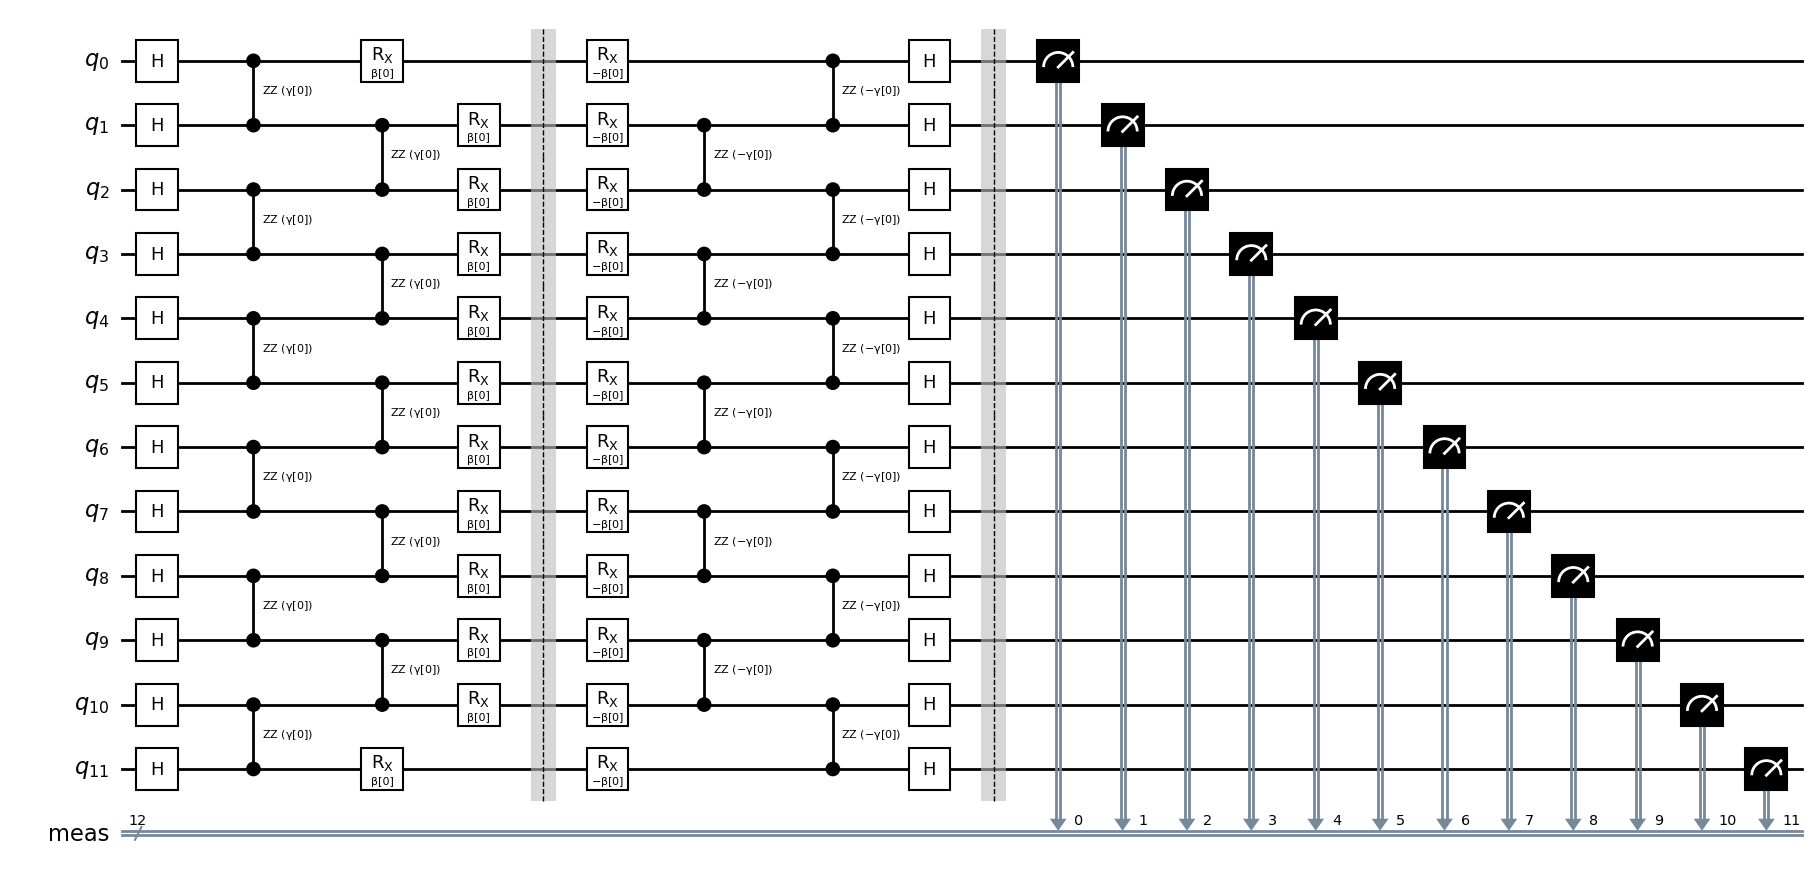

In [6]:
num_qubits = 12
p = 1
qc = build_compute_uncompute_qaoa_circuit(num_qubits, 4 * p)
qc.draw("mpl", style="bw", fold=-1)

In [7]:
betas, gammas = produce_qaoa_parameters(1, seed=0)
params = [gammas[0], betas[0]]
params

[-1.4464727375963786, 0.8605556614246863]

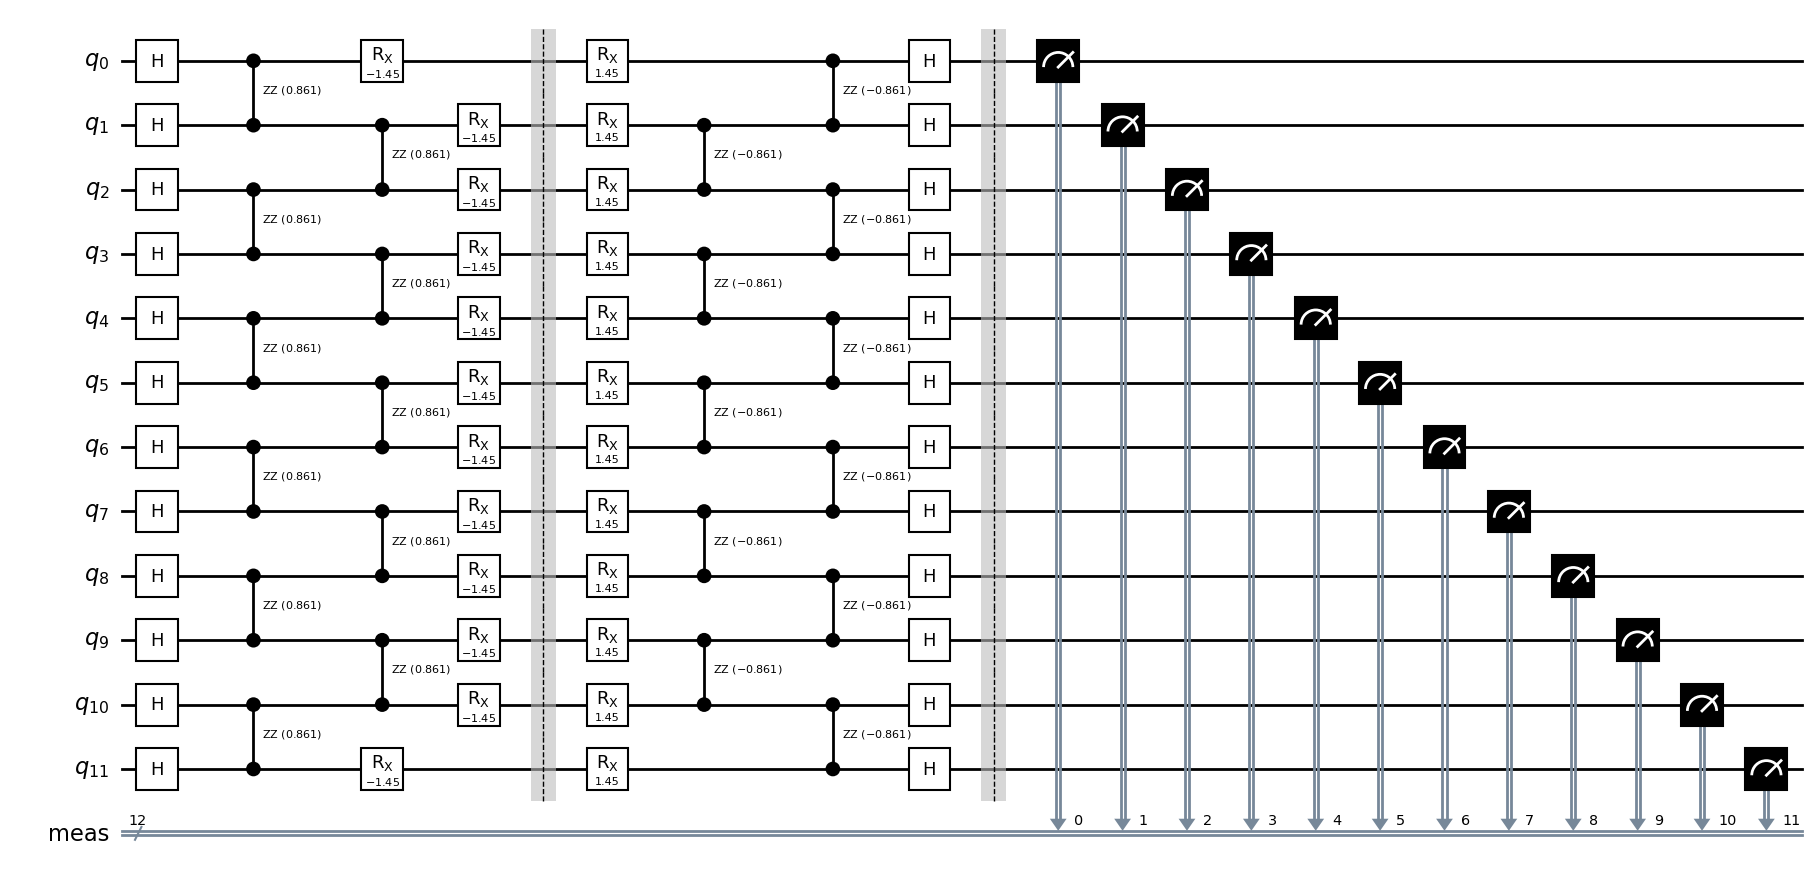

In [8]:
qc = qc.assign_parameters(params)
qc.draw("mpl", style="bw", fold=-1)

In [9]:
shots = 10000
observables = []

# Considering only wt-1 observables for brevity
for i in range(num_qubits):
    obs = "I" * i + "Z" * 1 + "I" * (num_qubits - i - 1)
    observables.append(obs)

observables

['ZIIIIIIIIIII',
 'IZIIIIIIIIII',
 'IIZIIIIIIIII',
 'IIIZIIIIIIII',
 'IIIIZIIIIIII',
 'IIIIIZIIIIII',
 'IIIIIIZIIIII',
 'IIIIIIIZIIII',
 'IIIIIIIIZIII',
 'IIIIIIIIIZII',
 'IIIIIIIIIIZI',
 'IIIIIIIIIIIZ']

In [10]:
qubits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
mit = mthree.M3Mitigation(backend)
mit.system_info["max_circuits"] = 1024
mit.cals_from_system(qubits)

In [12]:
cals = mit.cals_to_matrices()
cals

[None,
 array([[0.9977019 , 0.00189841],
        [0.00229812, 0.9981016 ]], dtype=float32),
 array([[0.99790174, 0.00259787],
        [0.00209826, 0.99740213]], dtype=float32),
 array([[9.99899983e-01, 8.99255276e-04],
        [1.00016594e-04, 9.99100745e-01]], dtype=float32),
 array([[0.9972023 , 0.00259787],
        [0.00279772, 0.99740213]], dtype=float32),
 array([[0.998801  , 0.00269777],
        [0.00119901, 0.99730223]], dtype=float32),
 array([[0.9943046 , 0.00529569],
        [0.0056954 , 0.9947043 ]], dtype=float32),
 array([[9.9910080e-01, 1.7985106e-03],
        [8.9919567e-04, 9.9820149e-01]], dtype=float32),
 array([[0.99720234, 0.00349724],
        [0.00279766, 0.99650276]], dtype=float32),
 array([[0.9986012 , 0.00159878],
        [0.0013988 , 0.9984012 ]], dtype=float32),
 array([[0.99560356, 0.0042966 ],
        [0.00439644, 0.9957034 ]], dtype=float32),
 array([[0.9976019 , 0.00279778],
        [0.00239807, 0.9972022 ]], dtype=float32),
 array([[0.9987011 , 0.0011990

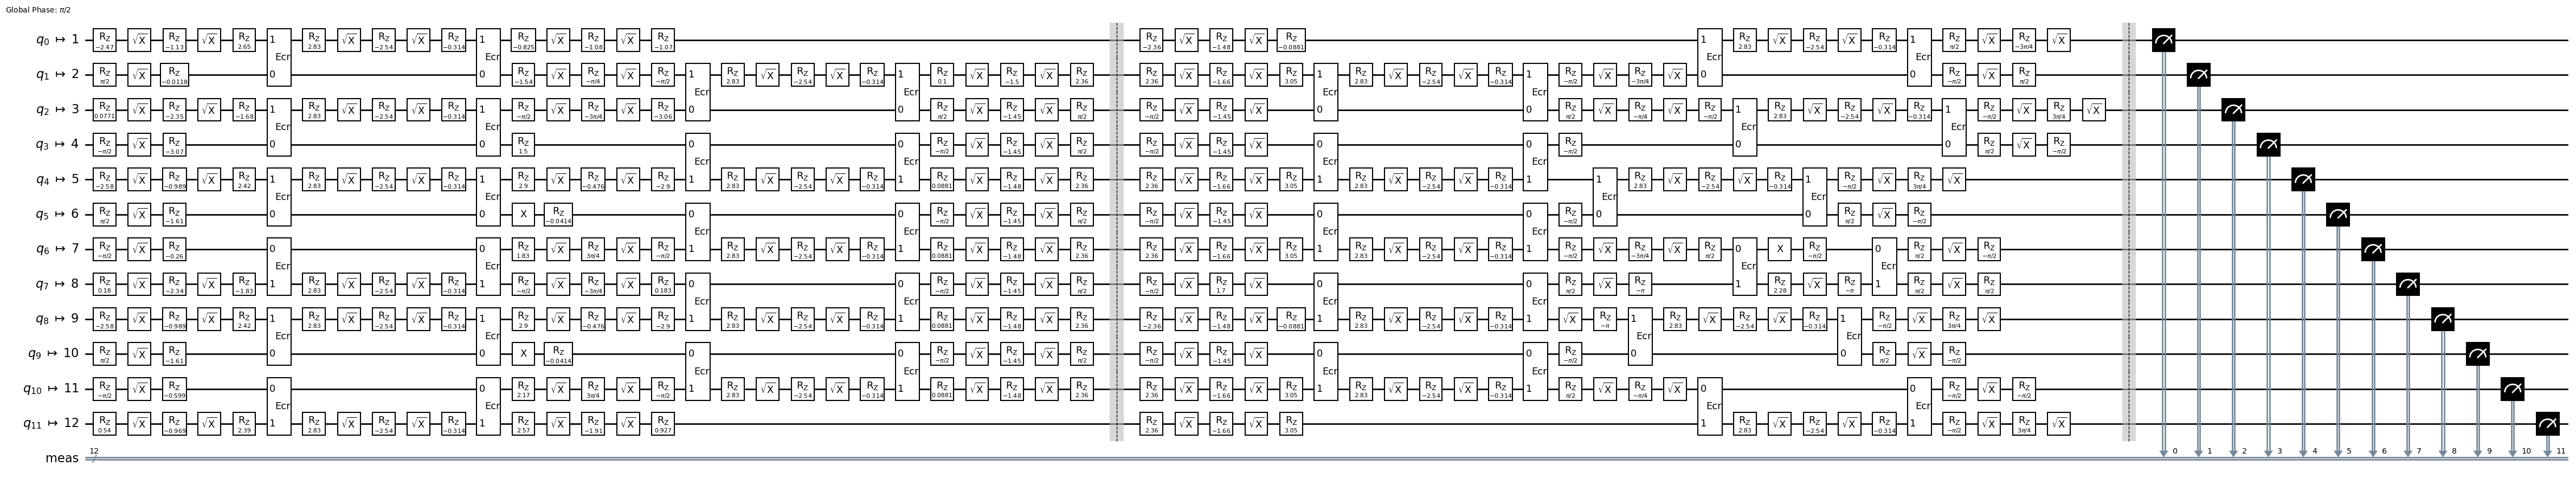

In [13]:
pm = generate_preset_pass_manager(2, backend, initial_layout=qubits)

qc = pm.run(qc)
qc.draw("mpl", style="bw", idle_wires=False, fold=-1)

In [14]:
counts_noisy = backend.run(qc, shots=shots).result().get_counts()

if sum(counts_noisy.values()) != 1:
    for key, val in counts_noisy.items():
        counts_noisy[key] = val / shots

In [15]:
A_mat_full, _ = mit.reduced_cal_matrix(counts_noisy, qubits)
A_mat_full

array([[9.7298884e-01, 1.8597409e-03, 2.5460476e-03, ..., 7.6630195e-11,
        9.1501141e-14, 2.3042917e-11],
       [2.2411924e-03, 9.7777218e-01, 5.8645919e-06, ..., 1.7651077e-13,
        2.1076467e-16, 5.3077287e-14],
       [2.0458787e-03, 3.9104293e-06, 9.7750652e-01, ..., 1.6112834e-13,
        1.9239710e-16, 4.8451745e-14],
       ...,
       [7.6943923e-11, 1.4706826e-13, 2.0134136e-13, ..., 9.9038166e-01,
        3.6063103e-08, 9.0818403e-06],
       [3.3917700e-14, 6.4829255e-17, 8.8753416e-17, ..., 1.3313384e-08,
        9.9567133e-01, 4.0033719e-09],
       [1.8816263e-11, 3.5964826e-14, 4.9237053e-14, ..., 7.3857659e-06,
        8.8190584e-09, 9.9011731e-01]], dtype=float32)

In [16]:
A_mat_3, _ = mit.reduced_cal_matrix(counts_noisy, qubits, distance=3)
A_mat_3

array([[9.7298884e-01, 1.8597409e-03, 2.5460476e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.2411924e-03, 9.7777218e-01, 5.8645919e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0458787e-03, 3.9104293e-06, 9.7750652e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.9038166e-01,
        3.6063103e-08, 9.0818403e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.3313384e-08,
        9.9567133e-01, 4.0033719e-09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.3857659e-06,
        8.8190584e-09, 9.9011731e-01]], dtype=float32)

In [17]:
quasi_full = mit.apply_correction(counts_noisy, qubits)

In [18]:
quasi_d3 = mit.apply_correction(counts_noisy, qubits, distance=3)

In [19]:
quasis = {
    dist: mit.apply_correction(counts_noisy, qubits, distance=dist)
    for dist in range(1, num_qubits + 1)
}

In [20]:
mitigated_expval = {}

for dist in range(1, num_qubits + 1):
    expvals = []
    for obs in observables:
        expvals.append(sampled_expectation_value(quasis[dist], obs))
    mitigated_expval[dist] = expvals

In [24]:
rmse = []

for dist in range(1, num_qubits + 1):
    expvals = mitigated_expval[dist]
    actual = [1] * len(expvals)
    mse = np.square(np.subtract(expvals, actual)).mean()
    rmse.append(np.sqrt(mse))

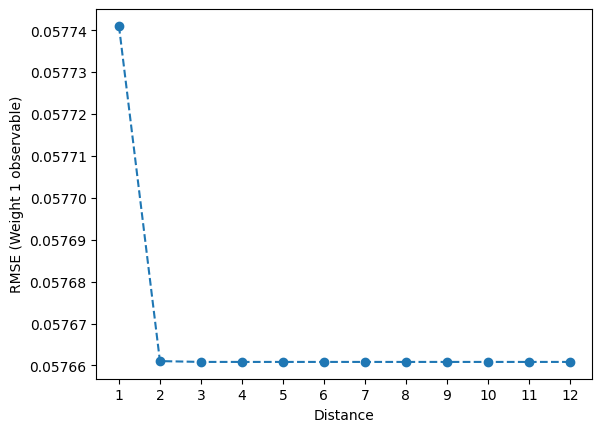

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_qubits + 1), rmse, "o--")
plt.ylabel("RMSE (Weight 1 observable)")
plt.xlabel("Distance")
plt.xticks(range(1, num_qubits + 1))
plt.show()